In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import os
import cv2
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage import exposure
import imageio
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model

In [2]:
trainingDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/cropped_hem'
trainingDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/cropped_all'
trainingDataAugHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_1/aug_hem'

validationDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/hem'
validationDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_0/all'

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.bmp')]

In [4]:
def crop_img(images, display=False):
    mask = images == 0

    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    cropped_image = images[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
    return cropped_image

In [5]:
def dataImport(path,pathType,dataType):
    imageList = []
    for dtype in dataType:
        if dtype == 'Validation':
            for i,j in zip(pathType,path):
                if i not in ['ALL','HEM']:
                    raise ValueError("Entry must be either 'ALL' or 'HEM'")
                else:
                    if i == 'HEM':
                        loadPath = get_imlist(j) 
                        for paths in loadPath:
                            imageList.append({'Images':Image.open(paths),'Labels':0,'CroppedImages':None})
                    else:
                        loadPath = get_imlist(j) 
                        for paths in loadPath:
                            imageList.append({'Images':Image.open(paths),'Labels':1,'CroppedImages':None})
            imageData = pd.DataFrame(imageList)
            imageData['CroppedImages'] = imageData['Images'].apply(lambda images: crop_img(np.array(images)))
        else:
            for i,j in zip(pathType,path):
                if i not in ['ALL','HEM']:
                    raise ValueError("Entry must be either 'ALL' or 'HEM'")
                else:
                    if i == 'HEM':
                        loadPath = get_imlist(j) 
                        for paths in loadPath:
                            imageList.append({'Images':Image.open(paths),'Labels':0})
                    else:
                        loadPath = get_imlist(j) 
                        for paths in loadPath:
                            imageList.append({'Images':Image.open(paths),'Labels':1})

            imageData = pd.DataFrame(imageList)
            print('Imdone...')
    return imageData

In [23]:
def load_images_labels_from_df(path, pathType, dataType, img_size):

    df = dataImport(path,pathType,dataType)
    images = []
    labels = []
    for dType in dataType:
        if dType == 'Validation':
            for _, row in df.iterrows():
                label = row['Labels']
                img_data = row['CroppedImages']
                img_resized = cv2.resize(img_data, (img_size, img_size), interpolation=cv2.INTER_LANCZOS4) #resize images (128*128, 256*256 etc)
                img_array = exposure.equalize_adapthist(img_resized,clip_limit=0.15,nbins=256)  # Normalize pixel values
                img_array = (img_array*255).astype(np.uint8)
                images.append(img_array)
                labels.append(label)
            
        else:
            print('Imhere...')
            for _, row in df.iterrows():
                label = row['Labels']
                img_data = np.array(row['Images'])
                img_resized = cv2.resize(img_data, (img_size, img_size), interpolation=cv2.INTER_LANCZOS4)
                images.append(img_resized)
                labels.append(label)

    labels = np.array(labels)
    images = np.array(images)
    return images, labels, len(images)

In [24]:
# Training Dataset
imageTrainData, labelTrainData, totalTrainData = load_images_labels_from_df([trainingDataALL,trainingDataHEM,trainingDataAugHEM],['ALL','HEM','HEM'],['Train'],256)

Imdone...
Imhere...


In [25]:
totalTrainData

6099

In [26]:
# Validation set
imageValidData, labelValidData, totalValidData = load_images_labels_from_df([validationDataALL,validationDataHEM],
                                                                  ['ALL','HEM'],['Validation'],256)

In [27]:
totalValidData

3527

In [31]:
labelTrainData.shape

(6099,)

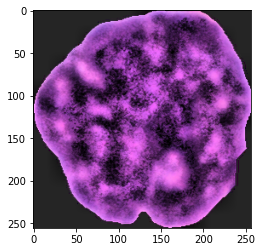

In [32]:
imshow(imageTrainData[200])

In [33]:
# Prepare data for CNN Model
datagen = preprocessing.image.ImageDataGenerator()
datagen.fit(np.array(imageTrainData))
datagen.fit(imageValidData)

In [34]:
trainLabel = np.array(labelTrainData)

In [39]:
validData_gen = datagen.flow(imageValidData,labelValidData,batch_size=32)
trainData_gen = datagen.flow(imageTrainData,labelTrainData,batch_size=32)

In [43]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min')
history = model.fit(
    trainData_gen,
    steps_per_epoch=floor(totalTrainData//32),
    epochs=50,
    validation_data=validData_gen,
    validation_steps=floor(totalValidData//32),
    callbacks=[earlyStopping]
)

loss, accuracy = model.evaluate(validData_gen,steps=floor(totalValidData//32))

Epoch 1/50
190/190 [==============================] - 368s 2s/step - loss: 15.5555 - accuracy: 0.7359 - val_loss: 0.5413 - val_accuracy: 0.7386
Epoch 2/50
190/190 [==============================] - 364s 2s/step - loss: 0.3601 - accuracy: 0.8380 - val_loss: 0.4888 - val_accuracy: 0.7912
Epoch 3/50
190/190 [==============================] - 363s 2s/step - loss: 0.2908 - accuracy: 0.8714 - val_loss: 0.4650 - val_accuracy: 0.7906
Epoch 4/50
190/190 [==============================] - 364s 2s/step - loss: 0.2662 - accuracy: 0.8871 - val_loss: 0.5077 - val_accuracy: 0.7881
Epoch 5/50
190/190 [==============================] - 360s 2s/step - loss: 0.2261 - accuracy: 0.9057 - val_loss: 0.5830 - val_accuracy: 0.7540
Epoch 6/50
190/190 [==============================] - 361s 2s/step - loss: 0.1883 - accuracy: 0.9186 - val_loss: 0.4960 - val_accuracy: 0.8006
Epoch 7/50
190/190 [==============================] - 358s 2s/step - loss: 0.1705 - accuracy: 0.9332 - val_loss: 0.6024 - val_accuracy: 0.797

In [44]:
os.mkdir('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models')

In [46]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/balancedModel.h5')

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
losses = history.history['loss']
val_loss = history.history['val_loss']

In [48]:
print(len(val_acc))

11


In [49]:
epoch = range(1, len(acc)+1)

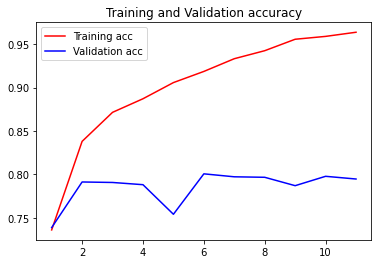

In [53]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

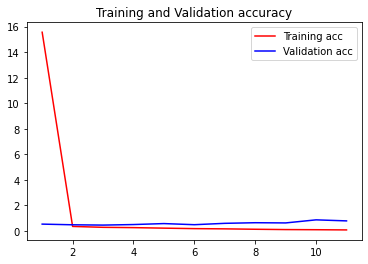

In [54]:
plt.plot(epoch, losses, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

## Test data AND Model Evaluation

In [56]:
testDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/hem'
testDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/all'

In [57]:
imageTestData, labelTestData, totalTestData = load_images_labels_from_df([testDataALL,testDataHEM],
                                                                  ['ALL','HEM'],['Validation'],256)

In [58]:
testImages = imageTestData.astype(np.float32)

In [59]:
y_predict = model.predict(testImages)

112/112 [==============================] - 38s 337ms/step


In [61]:
y_predict_binary = (y_predict>0.5).astype(int)

In [64]:
precision = precision_score(labelTestData,y_predict_binary)

In [66]:
recall = recall_score(labelTestData,y_predict_binary)

In [69]:
f1Score = f1_score(labelTestData, y_predict_binary)

In [72]:
confusionMatrix = confusion_matrix(labelTestData, y_predict_binary)

In [74]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.7760
Recall: 0.9223
f1_score: 0.8428


In [75]:
print(confusionMatrix)

[[ 442  654]
 [ 191 2266]]


In [94]:
print(f'True HEM: {442/1096:.4f}')
print(f'True ALL: {2266/2451:.4f}')

True HEM: 0.4033
True ALL: 0.9245


## Learning through model eyes

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 128)     

In [84]:
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
visualize_model = Model(inputs=model.inputs, outputs=[model.get_layer(name).output for name in layer_names])

In [85]:
imgPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/7.bmp'

In [87]:
image = Image.open(imgPath)
image = np.array(image)
cropImage = crop_img(image)
img_resized = cv2.resize(cropImage, (256, 256), interpolation=cv2.INTER_LANCZOS4) #resize images (128*128, 256*256 etc)
img_array = exposure.equalize_adapthist(np.array(img_resized),clip_limit=0.15,nbins=256)
img_array = (img_array*255).astype(np.uint8)

img_array = np.array(img_array)
img_label = 0
img_label = np.array([img_label])

In [88]:
singleImage = np.expand_dims(img_array, axis=0)

In [89]:
datagen.fit(singleImage)

In [90]:
imageAug = datagen.flow(singleImage, img_label, batch_size=1)

In [92]:
activations = visualize_model(singleImage)

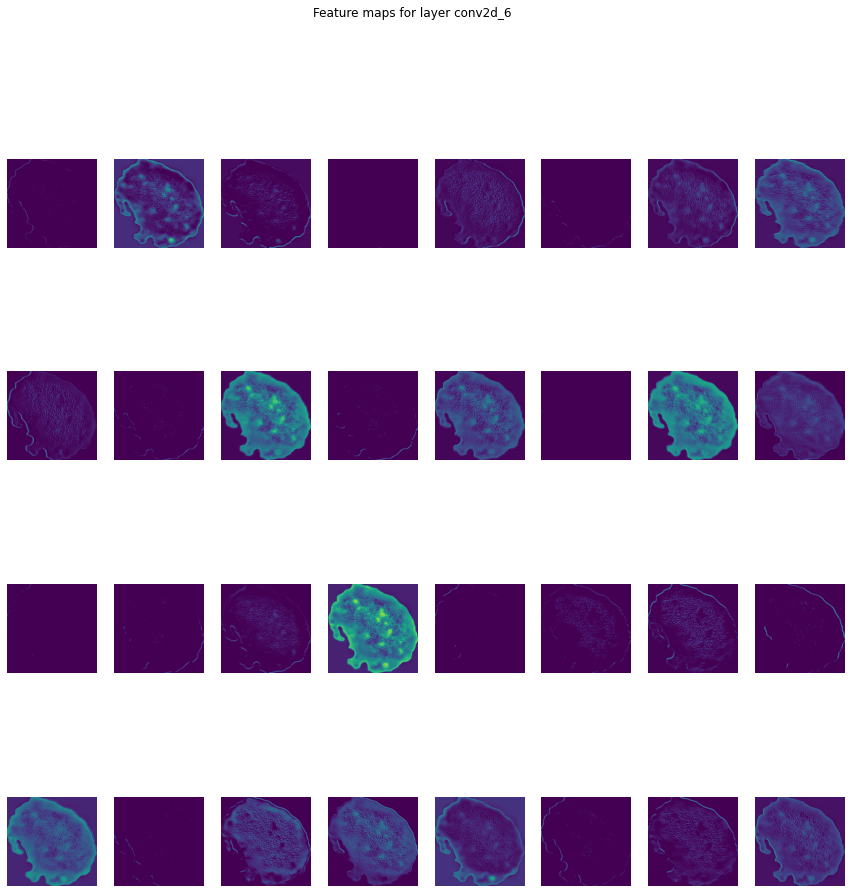

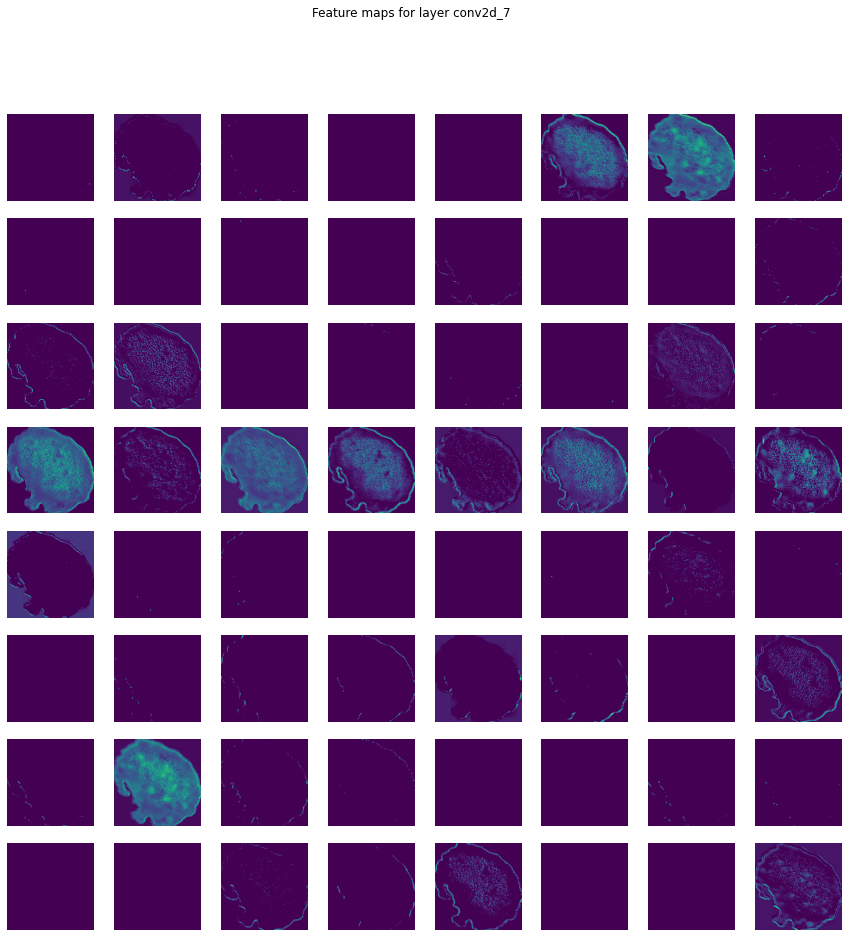

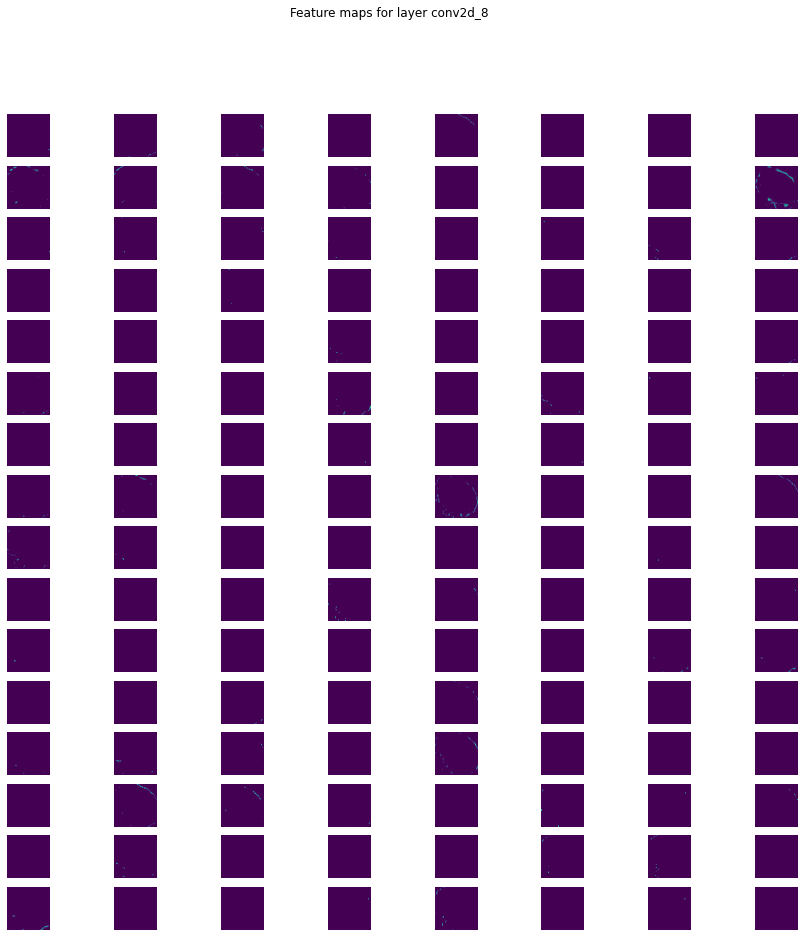

In [93]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // no_cols

        fig, axes = plt.subplots(grid_rows, no_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // no_cols, j % no_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)